# Отчет

In [1]:
import numpy as np
from tqdm.auto import trange
import matplotlib.pyplot as plt

In [ ]:
%matplotlib notebook

# Задание 1 
**Перемножение матриц**

In [ ]:
time = 0
n = 3000 #размер перемножаемых матриц
a = np.random.rand(n, n)
b = np.random.rand(n, n)
c = np.matmul(a, b)
np.savetxt('a.txt', a)
np.savetxt('b.txt', b)
np.savetxt('c.txt', c)
time = []
for k in range(1,12):
    v = !mpirun -np $k mpi_lab $n
    time.append(float(v[-2].split(' ')[2]))

<IPython.core.display.Javascript object>


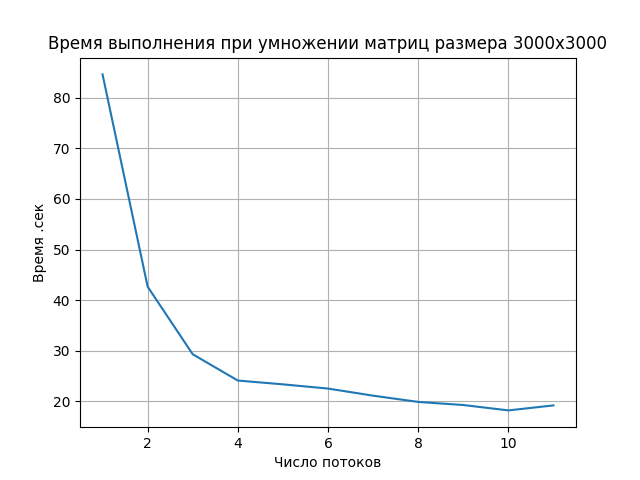

In [6]:
plt.plot(list(range(1, 12)), time)
plt.grid()
plt.title("Время выполнения при умножении матриц размера {}x{}".format(n, n))
plt.xlabel("Число потоков")
plt.ylabel("Время .сек");

## Исходный код
```c++
#include <mpi.h>
#include <cstdio>
#include <cstdlib>
#include <fstream>
using namespace std;

int main(int argc, char **argv)
{
    MPI_Init(&argc, &argv);
    int rank;
    int size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    size_t n;
    if (argc >= 2)
        n = strtoul(argv[1], nullptr, 10);
    else
    {
        cout <<"Need n as input arg"<<endl;
        return 1;
    }

    double *a, *c;
    double *b = (double*)malloc(n * n * sizeof(double));
    double *working_a = (double*)malloc(n * n * sizeof(double));
    double *working_c = (double*)malloc(n * n * sizeof(double));



    size_t num_workers = size;
    if (num_workers > n)
        num_workers = n;

    size_t block_size = num_workers > 0 ? n / num_workers : 0;
    size_t mod_block_size = n - num_workers * block_size;

    double start_time;
    if (rank == 0) {
        a = (double*)malloc(n * n * sizeof(double));
        c = (double*)malloc(n * n * sizeof(double));
        ifstream in_a("a.txt");
        ifstream in_b("b.txt");
        for (int i = 0; i < n * n; i++) {
            in_a >> a[i];
            in_b >> b[i];
        }
        start_time = MPI_Wtime();
    }
    MPI_Bcast(b, n*n, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    MPI_Scatter(a, block_size * n, MPI_DOUBLE, working_a, block_size * n, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    for (int row = 0; row < block_size; row++)
    {
        for (int i = 0; i < n; i++)
        {
            double sum = 0.0;
            for (int j = 0; j < n; j++)
                sum += working_a[row * n + j] * b[j * n + i];
            working_c[row * n + i] = sum;
        }
    }

    MPI_Gather(working_c, block_size * n, MPI_DOUBLE, c, block_size*n, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    if (rank == 0)
    {
        if (mod_block_size > 0) {
            int start_row = block_size * num_workers;
            for (int row = start_row; row < n; row++) {
                for (int i = 0; i < n; i++) {
                    double sum = 0.0;
                    for (int j = 0; j < n; j++)
                        sum += a[row * n + j] * b[j * n + i];
                    c[row * n + i] = sum;
                }
            }
        }

        double total_time = MPI_Wtime() - start_time;
        cout << "Matrix size: " << n <<endl;
        cout << "Total time: " << total_time <<" sec." <<endl;
    }

    MPI_Finalize();
    if (rank == 0)
    {
        ifstream in_c("c.txt");
        double err = 0;
        for(int i=0; i<n*n; i++)
        {
            double true_c;
            in_c >> true_c;
            err  = max(err, abs(true_c - c[i]));
        }
        cout << "Max error: " << err <<endl;
    }
    return 0;
}
```

# Задание 2
**Интегрирование**

In [ ]:
time = []
for k in range(1,12):
    v = !mpirun -np $k mpi_lab2
    if len(v) > 2:
        time.append(float(v[-3].split(' ')[2]))
    else:
        time.append(float(v[-1].split(' ')[2]))

<IPython.core.display.Javascript object>


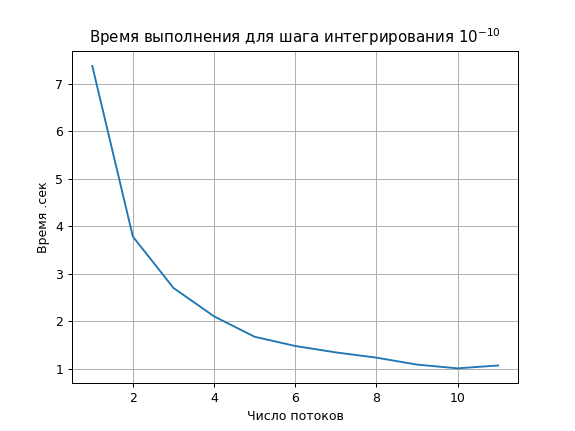

In [43]:
plt.figure()
plt.plot(list(range(1, 12)), time)
plt.grid()
plt.title("Время выполнения для шага интегрирования $10^{-10}$")
plt.xlabel("Число потоков")
plt.ylabel("Время .сек");

## Исходный код
```c++
#include <mpi.h>

double f(double x) {
    return x;
}
using namespace std;
int main(int argc, char* argv[]) {

    int rank;
    int size;

    double time;
    unsigned long long n = 10000000000;

    double a = 0.0;
    double b = 2.0;

    double sum = 0.0;
    double h = (b - a) / n;

    MPI_Status status;

    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    if (rank == 0)
        time = MPI_Wtime();

    for (int i = rank; i < n; i += size)
        sum += f(a + (i + 0.5) * h);
    sum *= h;

    double reduced_sum = 0;
    MPI_Reduce(&sum, &reduced_sum, 1, MPI_DOUBLE, MPI_SUM, 0, MPI_COMM_WORLD);
    if (rank == 0)
    {
        time = MPI_Wtime() - time;
        cout << "Integral value is : " << reduced_sum << endl;
        cout << "Time : " << time << endl;
    }
    MPI_Finalize();
    return 0;
}
```